## Análise de Eficácia de Intervenções - Ottokar Doerffel e rotatória Marajó

Insira abaixo os parâmetros do relatório e selecione "Cell" -> "Run All" para gerar os relatórios. Estarão armazenados no S3 da Amazon.

In [1]:
nome_arquivos = "OttokarMarajo"

dia_inicio_intervencao = 21
mes_inicio_intervencao = 7
ano_inicio_intervencao = 2018

dia_fim_intervencao = 21
mes_fim_intervencao = 7
ano_fim_intervencao = 2018

#Dias antes e depois da data de intervenção para análise de indicadores
periodo_analise = 7

horarios = [7,8,17,18]
fins_de_semana = False

lista_coordenadas = [
    (-26.31476, -48.86156, "Oeste", "Ottokar Doerffel sentido BR"),
    (-26.31476, -48.86156, "Leste", "Ottokar Doerffel sentido Centro"),
    (-26.31404, -48.86174, "Sul", "Marquês sentido Ottokar"),
    (-26.31338, -48.85934, "Oeste", "Ottokar na entrada da Marajó, sentido BR"),
    (-26.31338, -48.85934, "Leste", "Ottokar na entrada da Marajó, sentido Centro"),
    (-26.31306, -48.86244, "Oeste", "Marajó próximo a Marquês"),
]

In [2]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

from IPython.display import display
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
from shapely.geometry import LineString, Point
from shapely.wkt import loads as wkt_loads
import boto3
import io

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use("seaborn-darkgrid")

from src.data import processing_func

import importlib
pd.options.display.max_columns = 30
pd.options.display.max_rows = 200

In [3]:
#Connection and initial setup
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

importlib.reload(processing_func)

meta = processing_func.connect_database(DATABASE)

intervention_date_begin = datetime.date(day=dia_inicio_intervencao,
                                        month=mes_inicio_intervencao,
                                        year=ano_inicio_intervencao)
intervention_date_end = datetime.date(day=dia_fim_intervencao,
                                        month=mes_fim_intervencao,
                                        year=ano_fim_intervencao)

date_begin = intervention_date_begin - datetime.timedelta(days=periodo_analise)

date_end = intervention_date_end + datetime.timedelta(days=periodo_analise)

df_jams = processing_func.extract_df_jams(meta, date_begin, date_end, weekends=fins_de_semana)
print("Dado cru tem shape:")
display(df_jams.shape)

#Enrich and transform df_jams to geo_jams
importlib.reload(processing_func)
geo_jams = processing_func.transform_geo_jams(df_jams)
print("Dados transformados tem formato:")
display(geo_jams.shape)

#Connect to S3
s3 = boto3.client('s3',
                  aws_access_key_id=os.environ.get("aws_access_key"),
                  aws_secret_access_key=os.environ.get("aws_secret_key"))

# Filter holidays from list of holidays in Brazil, from ANBIMA
bucket = "smartmob-data"
key = "external/feriados_nacionais.xls"
result_dict = s3.get_object(Bucket=bucket, Key=key)
file_obj = io.BytesIO(result_dict["Body"].read())
holidays = pd.read_excel(file_obj, skipfooter=9)
holidays["Data"] = holidays["Data"].dt.date
holiday_list = holidays["Data"].tolist()
geo_jams = geo_jams[~geo_jams["date"].isin(holiday_list)]
print("Após excluir feriado o dado passa a ter o seguinte formato:")
display(geo_jams.shape)

#Let's drop blocked congestions. We'll treat them as outliers.
geo_jams = geo_jams[geo_jams["level"] != 5.0]
geo_jams = geo_jams[~geo_jams["date"].isin(holiday_list)]
print("Após excluir trânsitos extremos o dado passa a ter o seguinte formato:")
display(geo_jams.shape)

#Let's get data from selected periods only
geo_jams = geo_jams[geo_jams.hour.isin(horarios)]
print("Selecionando apenas os horários de interesse, o dado passa a ter o seguinte formato:")
display(geo_jams.shape)
display(geo_jams.sample(5))

Dado cru tem shape:


(98811, 10)

Dados transformados tem formato:


(98811, 20)

Após excluir feriado o dado passa a ter o seguinte formato:


(98811, 20)

Após excluir trânsitos extremos o dado passa a ter o seguinte formato:


(90945, 20)

Selecionando apenas os horários de interesse, o dado passa a ter o seguinte formato:


(32695, 20)

,start_time,id,uuid,street,level,length,speed_kmh,speed,delay,line,LonDirection,LatDirection,MajorDirection,date,hour,minute,period,minute_bin,jams_line_list,linestring
73910,2018-07-18 08:53:00-03:00,148193,33933422,Av. Placido Hugo de Oliveira,4,344,8.67,2.40833,124,"[{'x': -48.839805, 'y': -26.375829}, {'x': -48...",East,North,East/West,2018-07-18,8,53,-1,45 a 59,"[(-48.839805, -26.375829), (-48.839457, -26.37...",LINESTRING (715525.8687493603 7080888.83886124...
6622,2018-07-26 17:13:00-03:00,154203,816387616,R. Pres. de Gaulle,3,341,8.67,2.40833,110,"[{'x': -48.87717, 'y': -26.294337}, {'x': -48....",East,South,East/West,2018-07-26,17,13,1,0 a 14,"[(-48.87717, -26.294337), (-48.876735, -26.293...",LINESTRING (711945.3289924328 7089979.71487662...
77392,2018-07-17 18:49:00-03:00,147771,2131363304,R. Gothard Kaesemodel,3,1056,14.28,3.96667,159,"[{'x': -48.860671, 'y': -26.315067}, {'x': -48...",East,South,East/West,2018-07-17,18,49,1,45 a 59,"[(-48.860671, -26.315067), (-48.860536, -26.31...",LINESTRING (713555.0498489952 7087655.76082420...
60737,2018-07-19 17:49:00-03:00,149181,175198293,R. Tuiuti,3,736,15.86,4.40556,107,"[{'x': -48.821375, 'y': -26.248236}, {'x': -48...",East,South,North/South,2018-07-19,17,49,1,45 a 59,"[(-48.821375, -26.248236), (-48.821363, -26.24...",LINESTRING (717603.5843079531 7094994.86093220...
91984,2018-07-16 17:13:00-03:00,147003,2009486690,R. Florianópolis,3,469,9.36,2.60000,126,"[{'x': -48.836247, 'y': -26.325694}, {'x': -48...",East,South,East/West,2018-07-16,17,13,1,0 a 14,"[(-48.836247, -26.325694), (-48.835558, -26.32...",LINESTRING (715974.1154973535 7086437.70496549...


In [4]:
df_jams[df_jams.street.str.contains("Maraj", na=False)]

,start_time,id,uuid,street,level,length,speed_kmh,speed,delay,line
14538,2018-07-25 21:39:00,153526,728769818,R. Marajó,4,241,6.54,1.81667,109,"[{'x': -48.860475, 'y': -26.313161}, {'x': -48..."
15230,2018-07-25 21:23:00,153518,718356460,R. Marajó,4,241,6.93,1.92500,102,"[{'x': -48.860475, 'y': -26.313161}, {'x': -48..."


In [5]:
df_jams.start_time.max()

Timestamp('2018-07-27 12:53:00')

Let's get only the jams that contain the coordinates that were provided and add a column of before, during and after intervention

In [6]:
points_dict = {}
i=0
for point in lista_coordenadas:
    points_dict[i] = {}
    points_dict[i]["geometry"] = Point(point[1], point[0])
    points_dict[i]["direction_of_interest"] = point[2]
    points_dict[i]["desc"] = point[3]
    i += 1
    
replace_dict = {"Norte": "North",
                "Sul": "South",
                "Leste": "East",
                "Oeste": "West",
               }
df = (pd.DataFrame
      .from_dict(points_dict, orient='index')
      .replace(replace_dict)
     )
crs = "+init=epsg:4326"
geo_points = gpd.GeoDataFrame(df, crs=crs, geometry="geometry")
crs_2 = "+proj=utm +zone=22J, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
geo_points = geo_points.to_crs(crs_2)

#Apply buffer to jams' linestrings and run spatial join
geo_jams['jams_polygon'] = geo_jams.apply(lambda x: x["linestring"].buffer(10), axis=1)
geo_jams = geo_jams.set_geometry("jams_polygon")
geo_jam_specific = gpd.sjoin(geo_jams, geo_points, how="inner", op="contains", rsuffix="point")
print("Depois do spatial join shape é:")
display(geo_jam_specific.shape)

#Get data with the direction of interest
geo_jam_specific["direction_column"] = np.where(geo_jam_specific.direction_of_interest.isin(["North", "South"]),
                                       "LatDirection",
                                       "LonDirection")
geo_jam_specific["correct_direction"] = geo_jam_specific.apply(lambda row: row[row["direction_column"]] == row.direction_of_interest, axis=1)
geo_jam_specific = geo_jam_specific[geo_jam_specific.correct_direction]

#Label as before, during and after interventions
geo_jam_specific.loc[geo_jam_specific.start_time.dt.date < intervention_date_begin, "pre_post"] = "Antes"
geo_jam_specific.loc[(geo_jam_specific.start_time.dt.date >= intervention_date_begin) &
                     (geo_jam_specific.start_time.dt.date <= intervention_date_end), "pre_post"] = "Durante"
geo_jam_specific.loc[(geo_jam_specific.start_time.dt.date > intervention_date_end), "pre_post"] = "Depois"

display(geo_jam_specific.sample(5))

Depois do spatial join shape é:


(2573, 24)

,start_time,id,uuid,street,level,length,speed_kmh,speed,delay,line,LonDirection,LatDirection,MajorDirection,date,hour,minute,period,minute_bin,jams_line_list,linestring,jams_polygon,index_point,direction_of_interest,desc,direction_column,correct_direction,pre_post
26320,2018-07-24 18:21:00-03:00,152797,629210792,R. Ottokar Doerffel,3,566,14.46,4.01667,97,"[{'x': -48.865176, 'y': -26.318589}, {'x': -48...",East,North,North/South,2018-07-24,18,21,1,15 a 29,"[(-48.865176, -26.318589), (-48.864925, -26.31...",LINESTRING (713098.7692712514 7087272.98033982...,"POLYGON ((713116.9807204168 7087304.707545282,...",1,East,Ottokar Doerffel sentido Centro,LonDirection,True,Depois
32660,2018-07-24 08:17:00-03:00,152495,617129507,R. Ottokar Doerffel,3,1024,12.73,3.53611,212,"[{'x': -48.869761, 'y': -26.318695}, {'x': -48...",East,North,East/West,2018-07-24,8,17,-1,15 a 29,"[(-48.869761, -26.318695), (-48.868842, -26.31...",LINESTRING (712640.770488483 7087268.794175103...,"POLYGON ((712732.9723336351 7087274.277030107,...",1,East,Ottokar Doerffel sentido Centro,LonDirection,True,Depois
41900,2018-07-23 08:39:00-03:00,151786,512057019,R. Ottokar Doerffel,3,783,14.41,4.00278,134,"[{'x': -48.867246, 'y': -26.318876}, {'x': -48...",East,North,East/West,2018-07-23,8,39,-1,30 a 44,"[(-48.867246, -26.318876), (-48.866504, -26.31...",LINESTRING (712891.5578646491 7087244.59634499...,"POLYGON ((712965.949901354 7087245.308547243, ...",1,East,Ottokar Doerffel sentido Centro,LonDirection,True,Depois
91552,2018-07-16 17:33:00-03:00,147013,2009512689,R. Ottokar Doerffel,3,716,10.52,2.92222,163,"[{'x': -48.858388, 'y': -26.313039}, {'x': -48...",West,South,East/West,2018-07-16,17,33,1,30 a 44,"[(-48.858388, -26.313039), (-48.858908, -26.31...",LINESTRING (713786.7362700875 7087876.67762899...,"POLYGON ((713739.4117407614 7087836.714974678,...",3,West,"Ottokar na entrada da Marajó, sentido BR",LonDirection,True,Antes
42112,2018-07-23 08:01:00-03:00,151767,505007362,Av. Marquês de Olinda,4,425,8.73,2.42500,128,"[{'x': -48.863317, 'y': -26.311346}, {'x': -48...",East,South,North/South,2018-07-23,8,1,-1,0 a 14,"[(-48.863317, -26.311346), (-48.863351, -26.31...",LINESTRING (713297.6606487962 7088072.40377768...,"POLYGON ((713303.6623478472 7088035.364072381,...",2,South,Marquês sentido Ottokar,LatDirection,True,Depois


Calculate traffic indicators for each point of interest, for before, during and after the intervention

In [7]:
jams_pre_post = (geo_jam_specific.groupby(["index_point", "street", "desc", "pre_post", "direction_of_interest", "hour", "minute_bin"])
                                 .agg({"uuid": 'count',
                                       "length": "mean",
                                       "speed_kmh": "mean",
                                       "delay": "mean",
                                       "level": "mean",
                                       "period": "max",
                                        })
                                 .rename(columns={'uuid': "count_uuid"})
                                )
jams_pre_post

count_uuid  \
index_point street                desc                                         pre_post direction_of_interest hour minute_bin               
0           R. Ottokar Doerffel   Ottokar Doerffel sentido BR                  Antes    West                  7    15 a 29              1   
                                                                                                                   45 a 59             12   
                                                                                                              8    0 a 14              11   
                                                                                                                   15 a 29              6   
                                                                                                                   30 a 44              6   
                                                                                                                   45 a 59              1   
                                                                                                              17   0 a 14              17   
                                                                                                                   15 a 29             18   
                                                                                                                   30 a 44             20   
                                                                                                                   45 a 59             32   
                                                                                                              18   0 a 14              28   
                                                                                                                   15 a 29             32   
                                                                                                                   30 a 44             28   
                                                                                                                   45 a 59             28   
                                                                               Depois   West                  17   30 a 44              3   
                                                                                                                   45 a 59              4   
                                                                                                              18   0 a 14               5   
                                                                                                                   15 a 29             12   
                                                                                                                   30 a 44              5   
1           R. Ottokar Doerffel   Ottokar Doerffel sentido Centro              Antes    East                  7    0 a 14               1   
                                                                                                                   15 a 29             12   
                                                                                                                   30 a 44             22   
                                                                                                                   45 a 59             40   
                                                                                                              8    0 a 14              30   
                                                                                                                   15 a 29             32   
                                                                                                                   30 a 44             20   
                                                                                                                   45 a 59             19   
                                      

In [17]:
#Get unique datafiles
wazesignals_per_timeslot = (geo_jams
                            .groupby(["hour", "minute_bin", "period"])
                            .agg({"start_time": pd.Series.nunique})
                            .reset_index(level="period")
                            .rename(columns={"start_time": "count_datafiles"})
                           )

#Merge dataset with total number of waze signals, for each bin. jps stands for JamsPerSection

jps_per_timeslot = (jams_pre_post
                    .reset_index()
                    .set_index(["hour", "minute_bin"])
                    .join(wazesignals_per_timeslot, how="outer", rsuffix="right")
                    .sort_index()
                   )

#For highly meshed networks it is possible that jams from neighbor streets be double counted in other sections.
#We are accepting that, but we need to cap the probability to 1 in case the numbers of jams is bigger than the
#numbers of Waze signals.
jps_per_timeslot["slot_traffic_prob"] = jps_per_timeslot["count_uuid"]/jps_per_timeslot["count_datafiles"]
jps_per_timeslot["slot_traffic_prob"] = jps_per_timeslot["slot_traffic_prob"]

#Calculate Traffic Probability as per other Jupyter Notebook
jps_per_timeslot["notraffic_prob"] = 1 - jps_per_timeslot["slot_traffic_prob"]
jps_per_timeslot["weighted_speed_kmh"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["speed_kmh"]
jps_per_timeslot["weighted_length_jams"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["length"]
jps_per_timeslot["weighted_delay"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["delay"]
jps_per_timeslot["weighted_level"] = jps_per_timeslot["slot_traffic_prob"]*jps_per_timeslot["level"]

traffic_prob = (jps_per_timeslot.groupby(["index_point", "street","desc", "pre_post","period", "direction_of_interest"])
                               .agg({"notraffic_prob": np.prod,
                                     "slot_traffic_prob": np.sum,
                                     "weighted_speed_kmh": np.sum,
                                     "weighted_length_jams": np.sum,
                                     "weighted_delay": np.sum,
                                     "weighted_level": np.sum,
                                     "count_uuid": np.sum})
               )
wazesignals_per_period = wazesignals_per_timeslot.groupby("period").agg({"count_datafiles": np.sum})
traffic_prob = traffic_prob.join(wazesignals_per_period, on="period")

traffic_prob["traffic_prob"] = 1 - traffic_prob["notraffic_prob"]
traffic_prob["wavg_speed_kmh"] = traffic_prob["weighted_speed_kmh"] / traffic_prob["slot_traffic_prob"]
traffic_prob["wavg_length_jams"] = traffic_prob["weighted_length_jams"] / traffic_prob["slot_traffic_prob"]
traffic_prob["wavg_delay"] = traffic_prob["weighted_delay"] / traffic_prob["slot_traffic_prob"]
traffic_prob["wavg_level"] = traffic_prob["weighted_level"] / traffic_prob["slot_traffic_prob"]
traffic_prob["percent_jammed"] = traffic_prob["count_uuid"] / traffic_prob["count_datafiles"]
traffic_prob.drop(["weighted_speed_kmh",
                         "weighted_length_jams",
                         "weighted_delay",
                         "weighted_level",
                         "slot_traffic_prob",
                         "notraffic_prob"], axis=1, inplace=True)

#Calculate overall average speed, assuming a fixed free flow speed
free_flow_speed = 30
traffic_prob["calc_avg_speed"] = ((traffic_prob.count_uuid*traffic_prob.wavg_speed_kmh + 
                                  (traffic_prob.count_datafiles-traffic_prob.count_uuid)*free_flow_speed) /
                                   traffic_prob.count_datafiles)

#Improve readability
lkp_period = pd.DataFrame({"periodo": ["Manha", "Tarde"]}, index=[-1, 1])
traffic_prob = (traffic_prob
                .join(lkp_period, on="period")
                .reset_index("period", drop=True)
                .reset_index("street", drop=False)
                .set_index("periodo", append=True)
                .swaplevel(i=-1, j=-2)
                .sort_index(level="pre_post")
               )

#Connect to S3
s3 = boto3.client('s3',
                  aws_access_key_id=os.environ.get("aws_access_key"),
                  aws_secret_access_key=os.environ.get("aws_secret_key"))
timestamp = datetime.datetime.today().strftime("%Y_%m_%d_%H:%M:%S")
folder_name = "processed/%s_%s_AnaliseIntervencao/" % (timestamp, nome_arquivos)
file_name = folder_name + nome_arquivos + ".csv"
stream = io.StringIO()
jps_per_timeslot.to_csv(stream)
stream.seek(0)
s3.put_object(Body=stream.read(), Bucket='smartmob-data', Key=file_name)

traffic_prob

street  \
index_point desc                                         pre_post periodo direction_of_interest                          
0           Ottokar Doerffel sentido BR                  Antes    Manha   West                     R. Ottokar Doerffel   
                                                                  Tarde   West                     R. Ottokar Doerffel   
1           Ottokar Doerffel sentido Centro              Antes    Manha   East                     R. Ottokar Doerffel   
                                                                  Tarde   East                     R. Ottokar Doerffel   
2           Marquês sentido Ottokar                      Antes    Manha   South                  Av. Marquês de Olinda   
                                                                  Tarde   South                  Av. Marquês de Olinda   
3           Ottokar na entrada da Marajó, sentido BR     Antes    Manha   West                     R. Ottokar Doerffel   
                                                                  Tarde   West                     R. Ottokar Doerffel   
4           Ottokar na entrada da Marajó, sentido Centro Antes    Manha   East                     R. Ottokar Doerffel   
                                                                  Tarde   East                     R. Ottokar Doerffel   
0           Ottokar Doerffel sentido BR                  Depois   Tarde   West                     R. Ottokar Doerffel   
1           Ottokar Doerffel sentido Centro              Depois   Manha   East                     R. Ottokar Doerffel   
                                                                  Tarde   East                     R. Ottokar Doerffel   
2           Marquês sentido Ottokar                      Depois   Manha   South                  Av. Marquês de Olinda   
                                                                  Tarde   South                  Av. Marquês de Olinda   
5           Marajó próximo a Marquês                     Depois   Tarde   West                               R. Marajó   

                                                                                                 count_uuid  \
index_point desc                                         pre_post periodo direction_of_interest               
0           Ottokar Doerffel sentido BR                  Antes    Manha   West                           37   
                                                                  Tarde   West                          203   
1           Ottokar Doerffel sentido Centro              Antes    Manha   East                          176   
                                                                  Tarde   East                          178   
2           Marquês sentido Ottokar                      Antes    Manha   South                          13   
                                                                  Tarde   South                         154   
3           Ottokar na entrada da Marajó, sentido BR     Antes    Manha   West                           28   
                                                                  Tarde   West                          209   
4           Ottokar na entrada da Marajó, sentido Centro Antes    Manha   East                            4   
                                                                  Tarde   East                           20   
0           Ottokar Doerffel sentido BR                  Depois   Tarde   West                           29   
1           Ottokar Doerffel sentido Centro              Depois   Manha   East                          131   
                                                                  Tarde   East                          111   
2           Marquês sentido Ottokar                      Depois   Manha   South                           8   
                                                                  Tarde   South                         144   
5           Marajó próximo a

<Figure size 432x288 with 0 Axes>

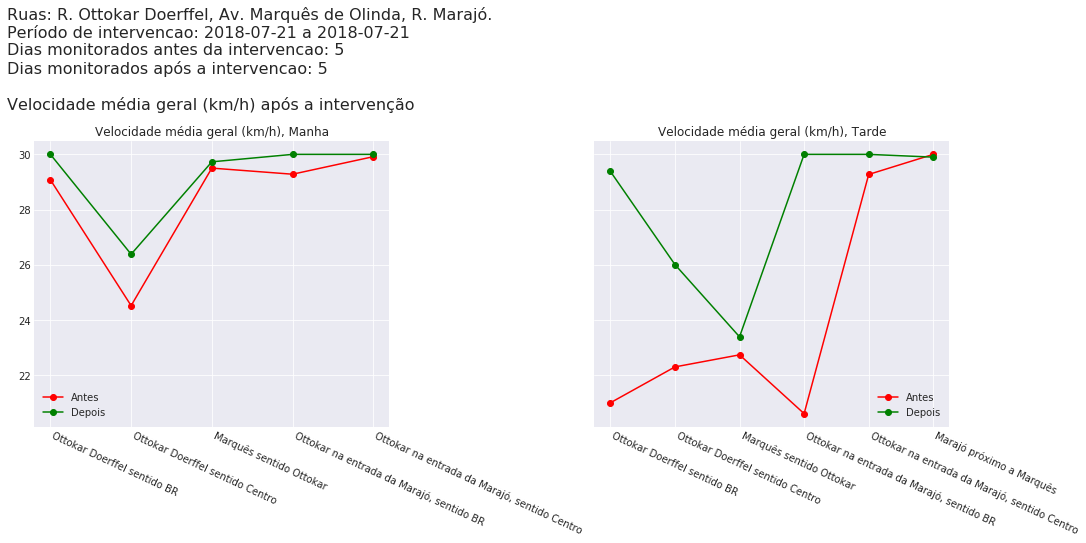

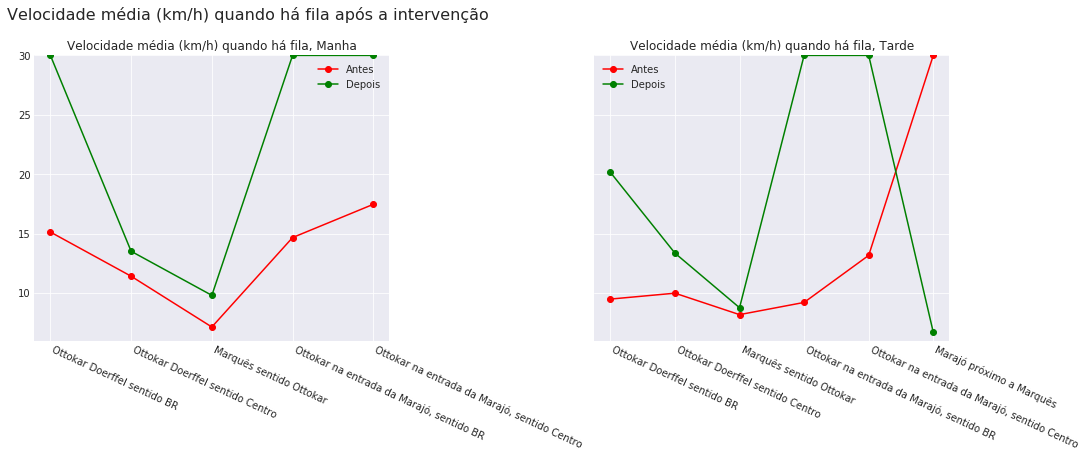

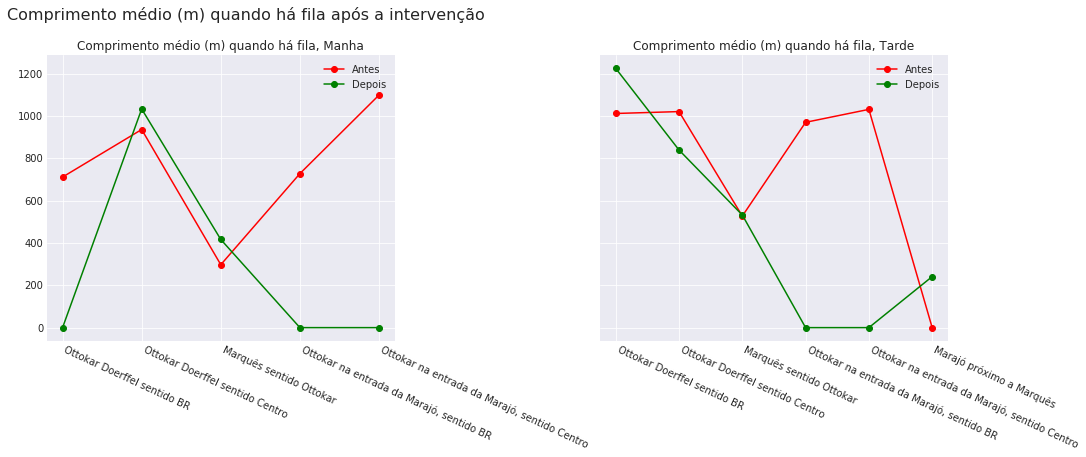

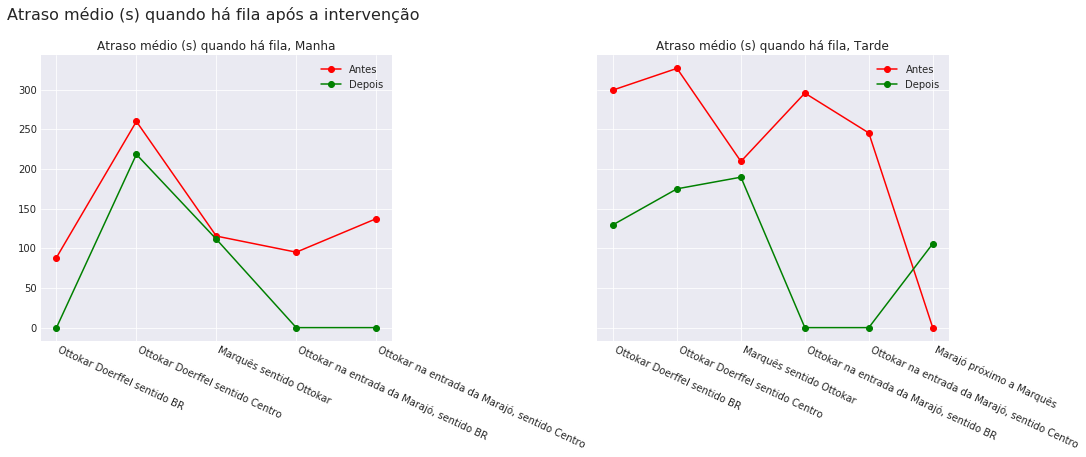

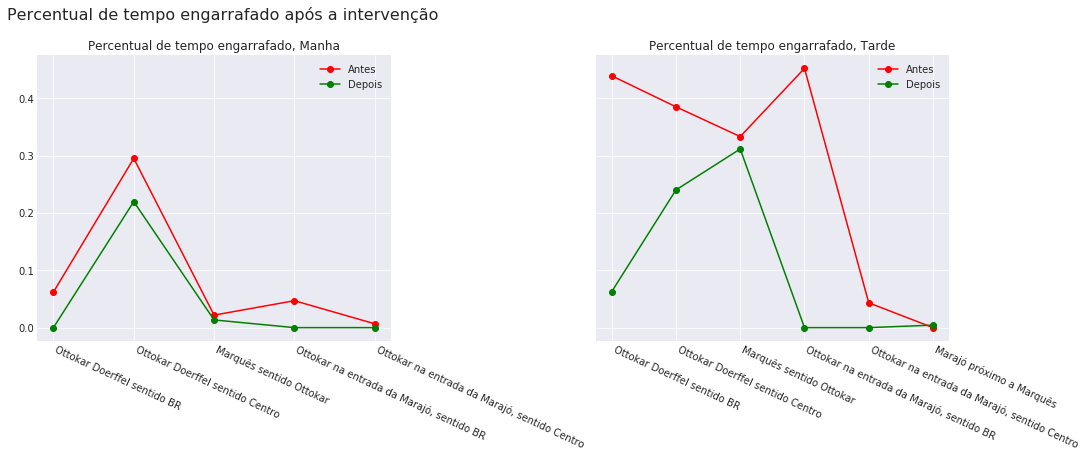

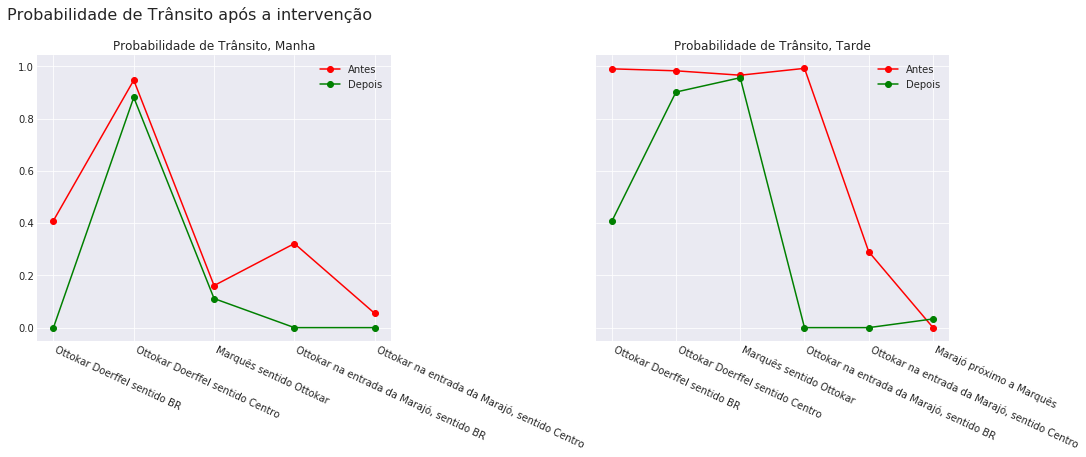

In [18]:
days_before = geo_jam_specific.loc[geo_jam_specific.pre_post == "Antes", "start_time"].dt.date.nunique()
days_after = geo_jam_specific.loc[geo_jam_specific.pre_post == "Depois", "start_time"].dt.date.nunique()

#Build chart

bar_width = 0.35
opacity = 0.35
index = traffic_prob.index.get_level_values("pre_post").unique().tolist()
directions = traffic_prob.index.get_level_values("direction_of_interest").unique().tolist()
streets = traffic_prob.street.unique().tolist()
kpi_names = {"calc_avg_speed": "Velocidade média geral (km/h)",
             "wavg_speed_kmh": "Velocidade média (km/h) quando há fila",
             "wavg_length_jams": "Comprimento médio (m) quando há fila",
             "wavg_delay": "Atraso médio (s) quando há fila",
             "percent_jammed": "Percentual de tempo engarrafado",
             "traffic_prob": "Probabilidade de Trânsito"
            }
kpi_cols = list(kpi_names.keys())
kpi_labels = list(kpi_names.values())

plt.clf()

for i in range(0, len(kpi_cols)):
    f, axs = plt.subplots(1, 2, sharey=True)
    f.set_figheight(6)
    f.set_figwidth(15)
    
    if i == 0:
        suptitle = "\n".join([
                            "Ruas: " + ", ".join(streets) + ".",
                            "Período de intervencao: " + str(intervention_date_begin) + " a " + str(intervention_date_end),
                            "Dias monitorados antes da intervencao: " + str(days_before),
                            "Dias monitorados após a intervencao: " + str(days_after),
                            "",            
                            "%s após a intervenção" % (kpi_names[kpi_cols[i]]),
                           ])
        y_pad=1.25
    else:
        suptitle = "%s após a intervenção" % (kpi_names[kpi_cols[i]])
        y_pad=1.05
        
    if kpi_cols[i] in ["calc_avg_speed", "wavg_speed_kmh"]:
        fill_value=free_flow_speed
    else:
        fill_value=0
                
    #SUPTITLE
    plt.suptitle(suptitle, fontsize=16, horizontalalignment='left', x=0, y=y_pad)
    
    periodos = ["Manha", "Tarde"]
    for j in range(0, len(periodos)):
        data_before = traffic_prob.xs(["Antes", periodos[j]], level=["pre_post", "periodo"])
        data_after, data_before = (traffic_prob.xs(["Depois", periodos[j]], level=["pre_post", "periodo"])
                                              .align(data_before, axis=0, fill_value=fill_value)
                                  )
        data_before.reset_index(inplace=True)
        data_after.reset_index(inplace=True)

        axs[j].plot(data_before.desc.values, data_before[kpi_cols[i]].values, marker='o', color='red', label="Antes")
        axs[j].plot(data_after.desc.values, data_after[kpi_cols[i]].values, marker='o', color='green', label="Depois")
        axs[j].set_title(kpi_labels[i] + ', ' + periodos[j])
        axs[j].legend()
        axs[j].set_ylim(top=free_flow_speed) if kpi_cols[i] == "wavg_speed_kmh" else False

    #Save to S3
    for ax in f.axes:
        plt.sca(ax)
        plt.xticks(rotation=-25, ha="left")
        plt.tight_layout()
    file_name = folder_name + nome_arquivos + "%s.png" % (kpi_cols[i])
    buf = io.BytesIO()
    f.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    s3.put_object(Body=buf, Bucket='smartmob-data', ContentType='image/png', Key=file_name)
    
plt.show()